<pre>
     Author: <a href="https://www.doclrogers.com">David Rogers</a>
    License: MIT
Description: Training a handwritten digit classifier for use in a mobile application.
</pre>

# Setup

## Imports

In [1]:
# Imports
import os

import cv2
print('Open CV2 version', cv2.__version__)

import matplotlib
import matplotlib.pyplot as plt
print('Matplotlib version', matplotlib.__version__)

import numpy as np
print('NumPy version', np.__version__)

import tensorflow as tf
from tensorflow.contrib import lite
print('TensorFlow version', tf.__version__)

# Plotting inline
%matplotlib inline

Open CV2 version 4.0.0
Matplotlib version 3.0.3
NumPy version 1.16.3
TensorFlow version 1.12.0


In [2]:
# Data set
MNIST = tf.keras.datasets.mnist

In [3]:
# Set random seed for consistency
np.random.seed(64)

## Read in Data

In [4]:
(x_train, y_train),(x_test, y_test) = MNIST.load_data()
class_names = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

print('Image size:', x_train[0,].shape)

Image size: (28, 28)


Sample raw MNIST image:


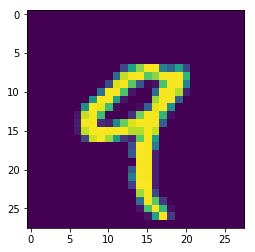

In [5]:
print('Sample raw MNIST image:')
plt.imshow(x_train[4,])
plt.show()

NOTE: Image is white writing on black background

## Pre-process Data

* Scale pixels from \[0, 255\] to \[0, 1\]
* Add Gaussian noise to the image to help improve results when captured with real-world mobile cameras
* Invert colors for black writing on white background

In [6]:
# Training set
x_train = x_train / 255.0 # Scale
x_train = np.maximum.reduce([np.random.normal(0.3, 0.1, x_train.shape), x_train]) # Add noise
x_train = 1 - x_train # Invert colors

# Test set
x_test = x_test / 255.0
x_test = np.maximum.reduce([np.random.normal(0.3, 0.1, x_test.shape), x_test])
x_test = 1 - x_test

Sample preprocessed MNIST image:


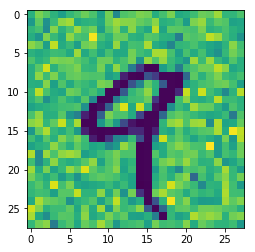

In [7]:
print('Sample preprocessed MNIST image:')
plt.imshow(x_train[4,])
plt.show()

# Train

Create a basic neural network for classifying MNIST images (See [Get Started with TensorFlow](https://www.tensorflow.org/tutorials)). Then fit to the training set.

In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
model.fit(x_train, y_train, epochs=10)

Epoch 1/10
60000/60000 [==============================] - 6s 102us/step - loss: 0.5761 - acc: 0.8212
Epoch 2/10
60000/60000 [==============================] - 6s 97us/step - loss: 0.3729 - acc: 0.8855
Epoch 3/10
60000/60000 [==============================] - 6s 97us/step - loss: 0.3096 - acc: 0.9044
Epoch 4/10
60000/60000 [==============================] - 6s 97us/step - loss: 0.2724 - acc: 0.9156
Epoch 5/10
60000/60000 [==============================] - 6s 97us/step - loss: 0.2463 - acc: 0.9253
Epoch 6/10
60000/60000 [==============================] - 6s 97us/step - loss: 0.2234 - acc: 0.9305
Epoch 7/10
60000/60000 [==============================] - 6s 97us/step - loss: 0.2176 - acc: 0.9325
Epoch 8/10
60000/60000 [==============================] - 6s 97us/step - loss: 0.2022 - acc: 0.9377
Epoch 9/10
60000/60000 [==============================] - 6s 98us/step - loss: 0.1914 - acc: 0.9386
Epoch 10/10
60000/60000 [==============================] - 6s 98us/step - loss: 0.1819 - acc: 0.942

# Evaluate

Evaluate on some handwritten digits of your own!

In [10]:
images = []
images.append(cv2.imread('../images/mnist/IMG_20190503_210852.jpg', 0))
images.append(cv2.imread('../images/mnist/IMG_20190503_210856.jpg', 0))
images.append(cv2.imread('../images/mnist/IMG_20190503_210859.jpg', 0))
images.append(cv2.imread('../images/mnist/IMG_20190503_210903.jpg', 0))
images.append(cv2.imread('../images/mnist/IMG_20190503_210907.jpg', 0))
images.append(cv2.imread('../images/mnist/IMG_20190503_210920.jpg', 0))
images.append(cv2.imread('../images/mnist/IMG_20190503_210927.jpg', 0))
images.append(cv2.imread('../images/mnist/IMG_20190503_210931.jpg', 0))
images.append(cv2.imread('../images/mnist/IMG_20190503_210936.jpg', 0))
images.append(cv2.imread('../images/mnist/IMG_20190503_210949.jpg', 0))

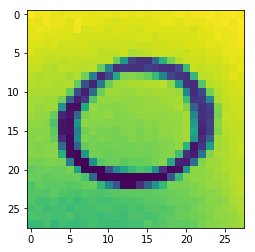

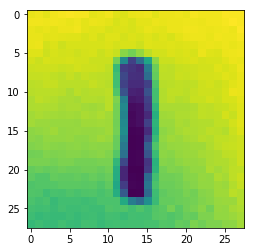

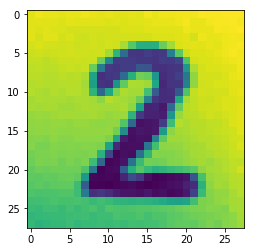

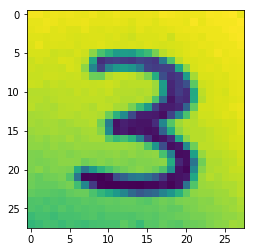

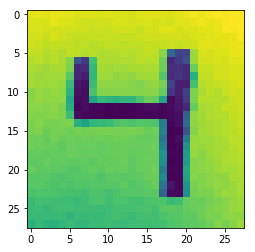

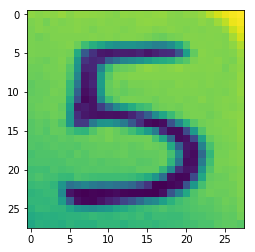

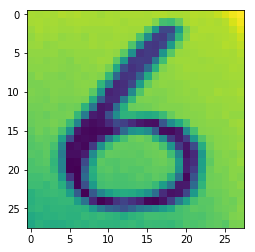

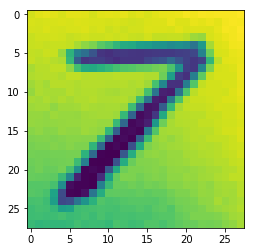

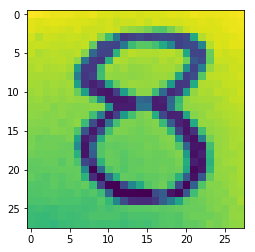

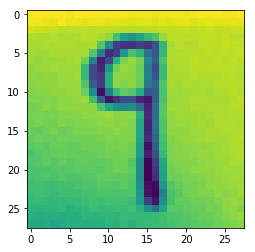

In [11]:
# Pre-process each image for inference
images_p = []
for img in images:
    tmp = cv2.resize(img, (28, 28)) / 255
    images_p.append(tmp)
    plt.imshow(tmp)
    plt.show()
    
images_p = np.stack(images_p)

In [12]:
# Predict results
results = model.predict(images_p)
results.shape

(10, 10)

In [13]:
print('Probabilities for each class:')
results[3]

Probabilities for each class:


array([2.0635023e-11, 2.1812593e-08, 1.2931856e-04, 9.9924421e-01,
       1.1887081e-13, 1.9451358e-08, 2.2896227e-16, 3.4042547e-08,
       6.2522932e-04, 1.2233971e-06], dtype=float32)

This image should be a "4", thus the highest probablity value should be at index=3.

In [14]:
np.argmax(results, 1)

array([0, 1, 2, 3, 4, 5, 2, 2, 5, 1])

Overall, on my handwritten digits, the model get 6 of 10 correct (the first 6 coincidentally).

# Export model

In [15]:
# Keras format
model.save('mnist.h5')

In [16]:
# Convert to TensorFlow lite
converter = lite.TFLiteConverter.from_keras_model_file('mnist.h5')
mdl = converter.convert()
with open('mnist.tflite', 'wb') as mfile:
    mfile.write(mdl)

INFO:tensorflow:Froze 4 variables.
INFO:tensorflow:Converted 4 variables to const ops.
